In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from torch import nn
from tqdm.auto import tqdm

# Import custom functions
import training_functions, nonlinear_model_classes, data_setup, utils

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

dictionary saved successfully to file
Device: cpu


# Non-linear regression

Our goal is to train a simple neural network to fit a well-behaved function fuction (no delta functions, discontinuities etc.) in a given range. We will choose

$$f(x)=x-x^3+x^6, \quad x\in[-1,1],$$

but other functions should work with the architecture here.

The workflow is as follows
1. Generate data and prepare it as input of a PyTorch model.
2. Setup the model, loss function and optimizer.
3. Perform the training loop.
4. Evaluate the model.
5. Check the influence of the number of hidden layers and the number of nodes in hidden layers.

Some functionalities are coded in external files:
* The functions helping to set up the DataLoaders are defined in `data_setup.py`
* The functions defining training step, testing step, and training loop are defined in `training_functions`.
* The class with model architecture is defined in `nonlinear_model_classes.py`
* The `models` folder contains pretrained models.

Let's define the function $f(x)$.

In [2]:
def test_function(x): return x - x**3 + x**6

## 1. Generate data.

We will discetize the x-axis from -1 to 1 and select from it 2000 points. Then we will evaluate $f(x)$ for these points



In [3]:
NUM_POINTS = 2000

# Generate the points on x_axis (features)
X = np.linspace(-1,1,NUM_POINTS)
# Generate the y-axis points (labels)
y = test_function(X)
print(f"Number of features: {len(X)} | Number of labels: {len(y)}")

Number of features: 2000 | Number of labels: 2000


Text(0.5, 1.0, '$f(x)=x-x^3+x^6$')

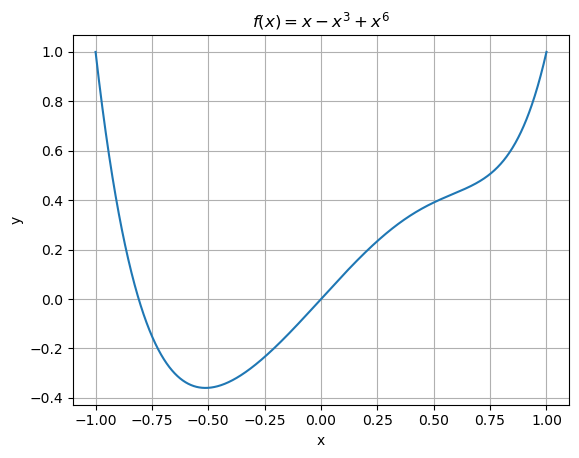

In [4]:
plt.plot(X,y)
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.title(r"$f(x)=x-x^3+x^6$")

### 1.1. Generate train and test sets

* Traning - 80% of data
* Testing - 20% of data

The data generation functionalities are implemented in `data_setup.py`

In [5]:
BATCH_SIZE = 128
TEST_SIZE = 0.2

# Setup the DataLoaders
train_dataloader, test_dataloader, X_test, y_test = data_setup.generate_dataloaders(
    X, y,
    batch_size = BATCH_SIZE,
    test_size = TEST_SIZE
)

## 2. Setup the model, loss function, and optimizer.

The user can set up the following hyperparameters
* `HIDDEN_LAYERS` - number of hidden layers
* `HIDDEN_LAYER_NODES` - number of nodes in the hidden layer

Model achitecture:
* Initial layer: `nn.Linear` + `nn.ReLU` | 1 $\rightarrow$ `HIDDEN_LAYER_NODES`
* Middle layers: `nn.Linear` + `nn.ReLU` | `HIDDEN_LAYER_NODES` $\rightarrow$ `HIDDEN_LAYER_NODES`
* Final layer: `nn.Linear` | `HIDDEN_LAYER_NODES` $\rightarrow$ 1

Loss function: `nn.L1Loss`

Optimizer: `torch.optim.Adam`

This architecture is defined in `NonLinearFit` class in `nonlinear_model_classes.py`.

In [6]:
HIDDEN_LAYER_NODES = 15
HIDDEN_LAYERS = 15

model = nonlinear_model_classes.NonLinearFit(HIDDEN_LAYERS,HIDDEN_LAYER_NODES)

loss_fn = nn.L1Loss()

optimizer = torch.optim.Adam(params = model.parameters())

In [7]:
# Dummy forward pass
model(torch.Tensor(X[[4]]))

tensor([-0.2044], grad_fn=<ViewBackward0>)

## 3. Code the training loop

We will functionize the training loop since the training will be repeated for multiple models.

In [8]:
# Number of epochs
NUM_EPOCHS = 150

  0%|          | 0/150 [00:00<?, ?it/s]

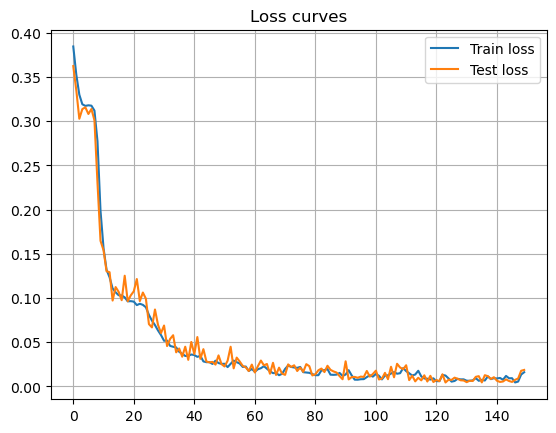

In [9]:
training_functions.train_model(num_epochs = NUM_EPOCHS,
                               model = model,
                               loss_fn = loss_fn,
                               optimizer = optimizer,
                               train_dataloader = train_dataloader,
                               test_dataloader = test_dataloader,
                               device = device);

## 4. Evaluate the model.

Generate data from the model and compare them vs test data.

In [10]:
# Setup a list with model predictions
y_preds = []

# Generate data from the model
for idx in range(len(X_test)):
    y_preds.append( model(X_test[[idx]]).item() )

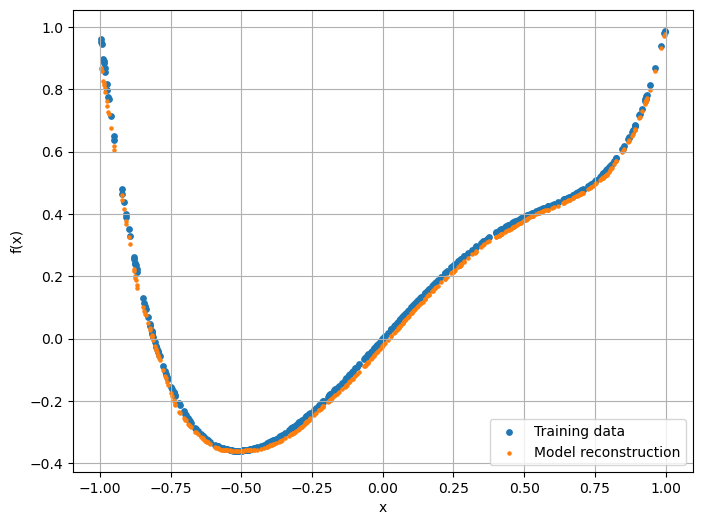

In [11]:
plt.figure(figsize = (8,6))
plt.scatter(X_test, y_test, s = 15, label = "Training data")
plt.scatter(X_test, y_preds, s = 5, label = "Model reconstruction")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.legend();

## 5. Check the influence of the number of hidden layers and the number of nodes in hidden layers.

We will plot the predictions of trained set models where
* the number of hidden layers will range from 1 to 5
* the number of neurons in hidden layers will range from 1 to 5

The trained models will be saved in the `models` folder.

In [12]:
MAX_HIDDEN_LAYERS = 5
MAX_HIDDEN_LAYER_NEURONS = 5

num_hidden_layers_list = range(1,MAX_HIDDEN_LAYERS + 1)
num_hidden_neurons_list = range(1,MAX_HIDDEN_LAYER_NEURONS + 1)

**Note** 

The cell below is commented, as evaluating it takes an extensive amount of time. It is responsible for training the models and saving them in external files.

The pre-trained models are stored in the `models` folder and are loaded later.

Evaluating the cell below removes the content of the `models` folder, and then saves the currently trained models there.

In [13]:
# # Number of epochs used for training
# NUM_EPOCHS = 150

# # Delete all files from `models` folder
# # This folder will contain the trained models
# utils.delete_files_in_directory("models")

# # Initialize the dictionary with loss curves
# # Key: tuple with (1) number of layers and (2) number of neurons in hidden layer
# # Value: loss curves 
# loss_dict = {}

# # Train the model for all possible sets of parameters
# for num_layers in num_hidden_layers_list:
#     for num_neurons in num_hidden_neurons_list:
#         print(f"Training for {num_layers} layers and {num_neurons} neurons")
        
#         # Setup the model
#         model = nonlinear_model_classes.NonLinearFit(hidden_layers = num_layers, 
#                                                      hidden_layer_nodes = num_neurons)
        
#         # Setup the loss and optimizer
#         loss_fn = nn.L1Loss()
#         optimizer = torch.optim.Adam(params = model.parameters())
        
#         # Train the model
#         loss_dict[(num_layers, num_neurons)] = training_functions.train_model(num_epochs = NUM_EPOCHS,
#                                                                               model = model,
#                                                                               loss_fn = loss_fn,
#                                                                               optimizer = optimizer,
#                                                                               train_dataloader = train_dataloader,
#                                                                               test_dataloader = test_dataloader,
#                                                                               device = device,
#                                                                               make_plots = False)
        
#         # Save the trained model
#         model_name = f"model_{num_layers}_{num_neurons}.pth"
        
#         utils.save_model(model = model, target_dir = "models", model_name = model_name)

# # Save the loss function dictionary
# utils.save_dict(loss_dict, save_path = "models", save_name = "loss_dict.pkl")

In [16]:
# Initialize the dictionary with reconstructions
# Key: tuple with (1) number of layers and (2) number of neurons in hidden layer
# Value: reconstruction - trained model acting on test data
reconstructions = {}

# Load the saved models and get reconstructions
for num_layers in num_hidden_layers_list:
    for num_neurons in num_hidden_neurons_list:
        # Setup model name as a string
        model_name = f"model_{num_layers}_{num_neurons}.pth"
        
        # Setup an instance of the model
        model = nonlinear_model_classes.NonLinearFit(hidden_layers = num_layers, 
                                                     hidden_layer_nodes = num_neurons)
        
        # Update the model parameters with saved data
        utils.load_model(model = model,
                         model_path = "models",
                         model_name = model_name)
        
        # Get model predictions
        # Setup a list with model predictions
        y_preds = []

        # Generate data from the model
        for idx in range(len(X_test)):
            y_preds.append( model(X_test[[idx]]).item() )
            
        reconstructions[(num_layers, num_neurons)] = y_preds
        
# Load the loss function dictionary
loss_dict = utils.load_dict(save_path = "models/loss_dict.pkl")

### 5.1. Reconstructions

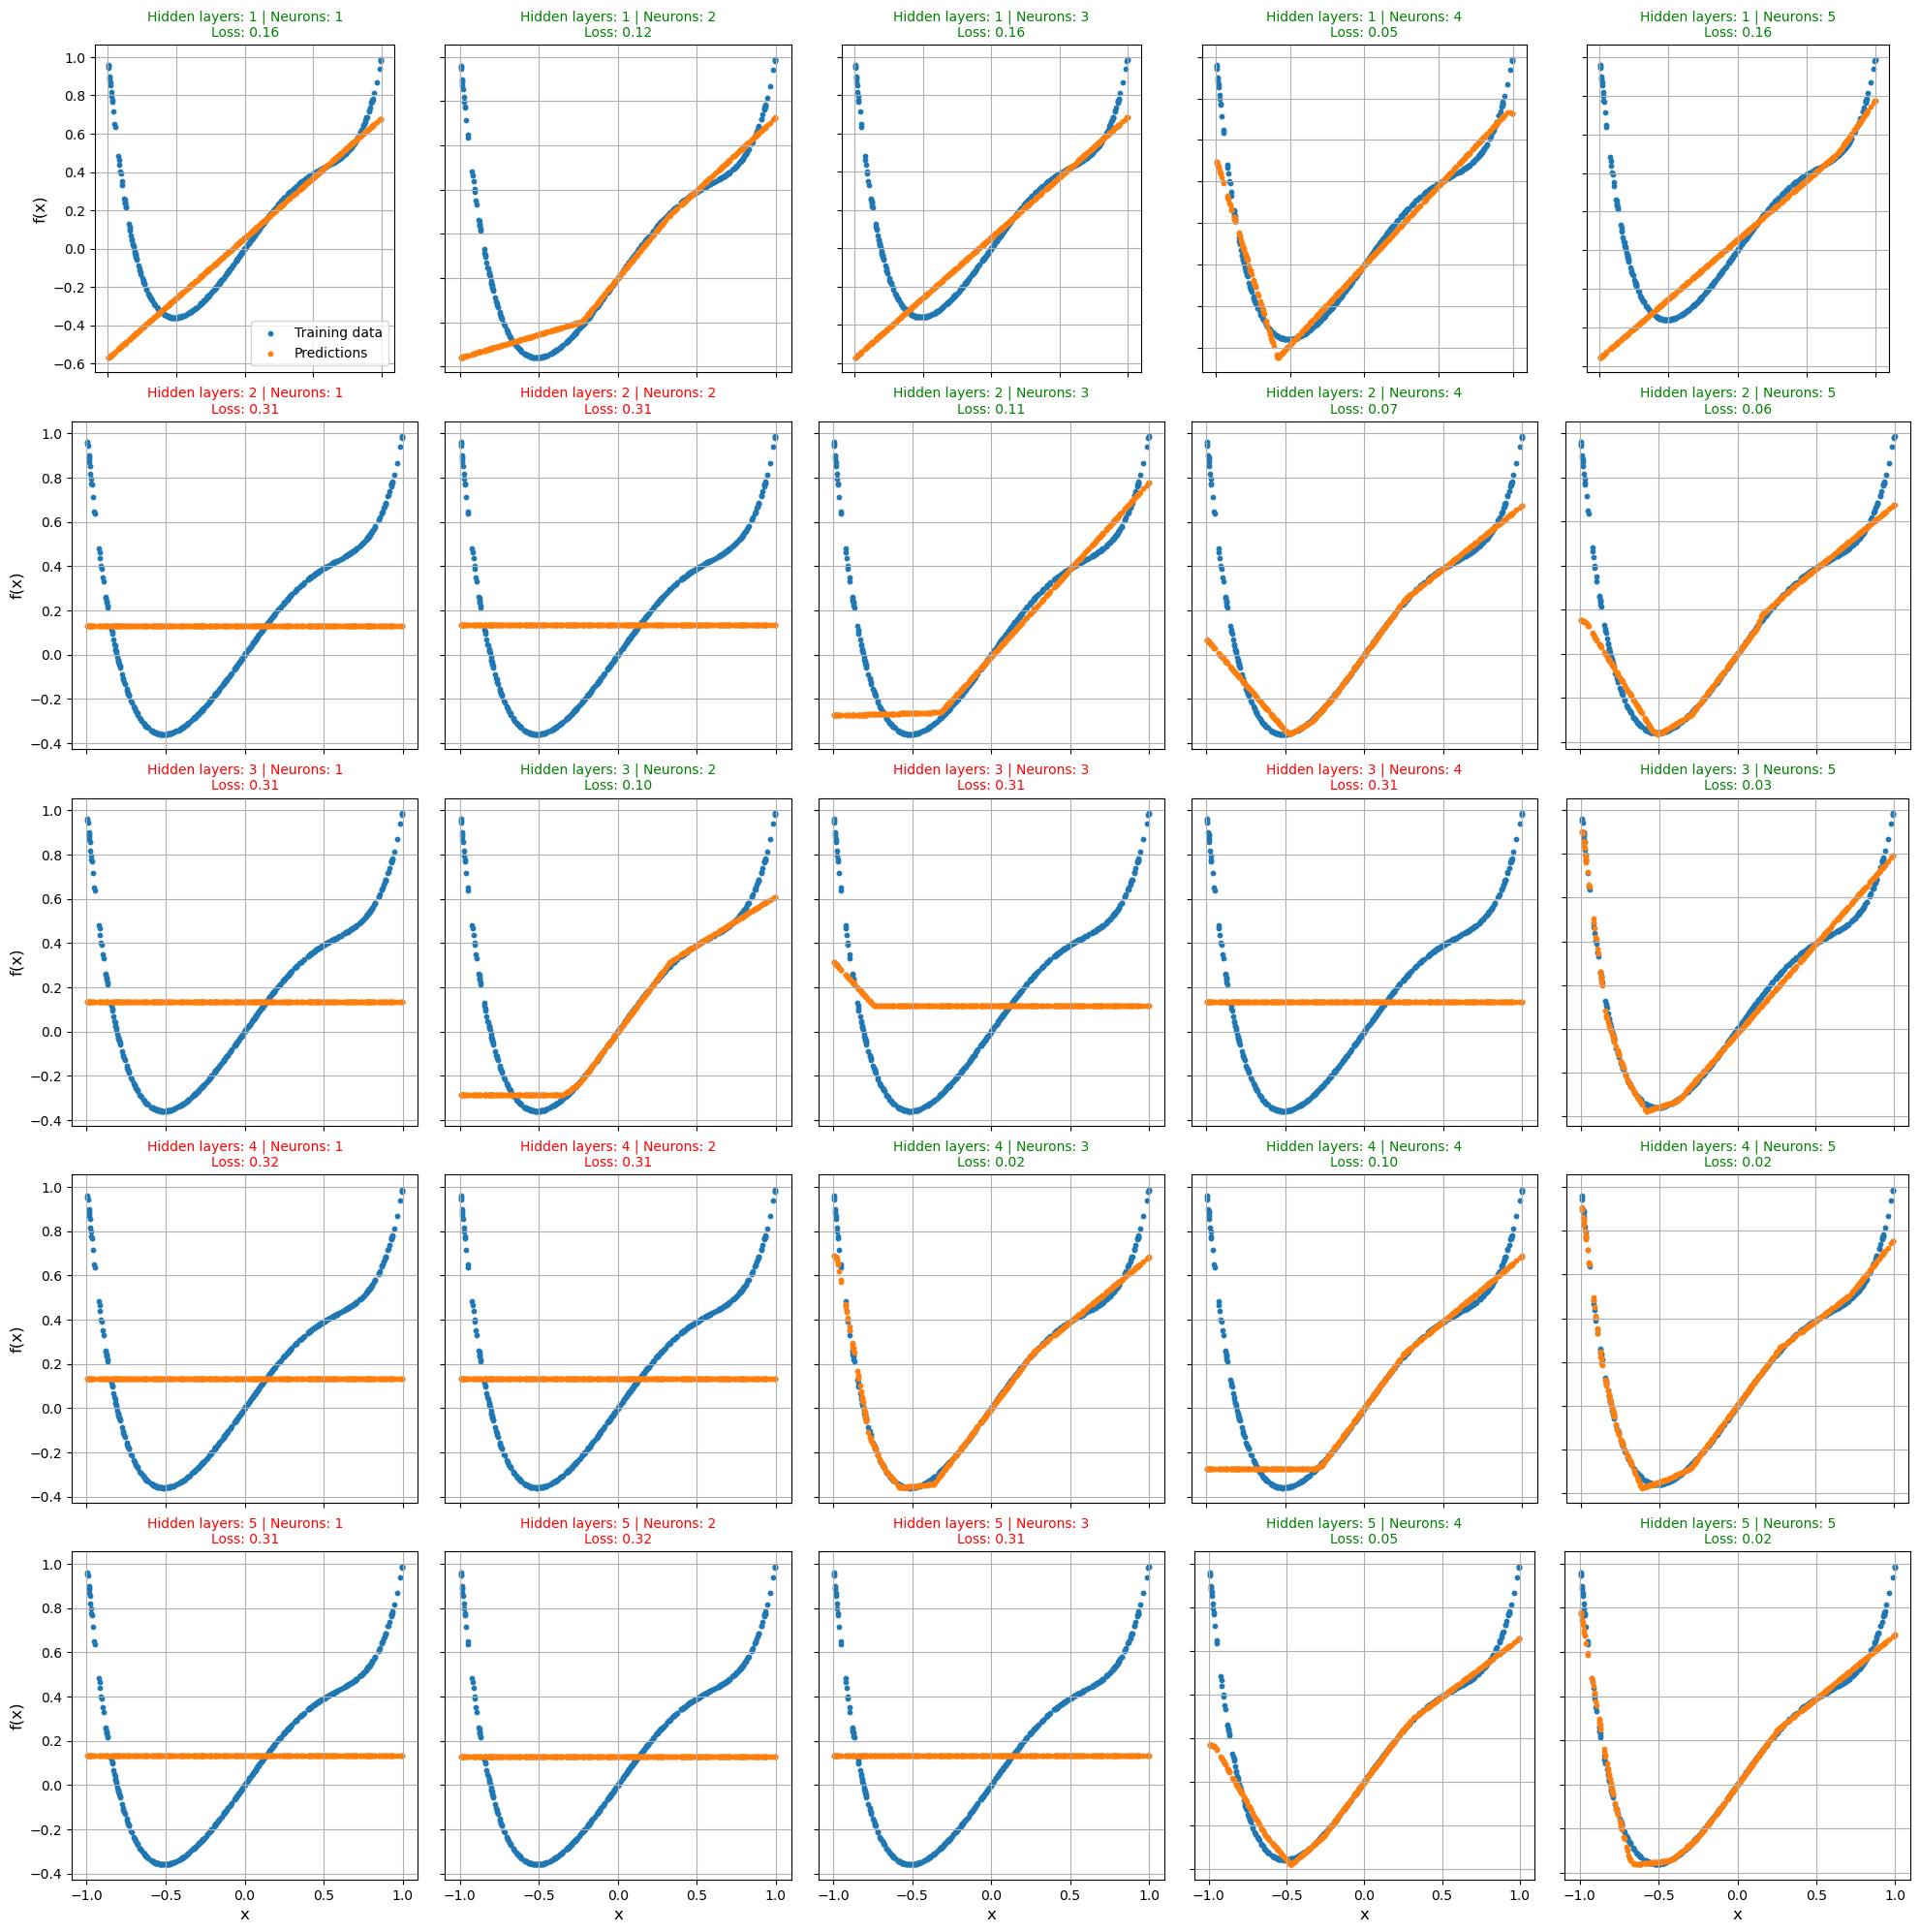

In [17]:
N_ROWS, N_COLS = len(num_hidden_layers_list), len(num_hidden_neurons_list)

fig, axs = plt.subplots(N_ROWS, N_COLS, figsize = (20,20))
for i in range(N_ROWS):
    for j in range(N_COLS):
        # Get data from `reconstructions` dictionary
        num_layers = num_hidden_layers_list[i]
        num_neurons = num_hidden_neurons_list[j]
        
        axs[i,j].scatter(X_test, y_test, s = 10, label = "Training data")
        axs[i,j].scatter(X_test, reconstructions[(num_layers,num_neurons)], s = 10, label = "Predictions")
        axs[i,j].set_aspect(1.4)
        axs[i,j].grid()
        final_loss = loss_dict[(num_layers,num_neurons)][0][-1]
        if final_loss > 0.3:
            title_color = "red"
        else:
            title_color = "green"
        axs[i,j].set_title(f"Hidden layers: {num_layers} | Neurons: {num_neurons}\nLoss: {final_loss:.2f}", 
                           fontsize = 10, color = title_color)

# Plot axis labels at the boundary plots
for i in range(N_COLS):
    axs[i,0].set_ylabel("f(x)", fontsize = 12)
for j in range(N_ROWS):
    axs[-1,j].set_xlabel("x", fontsize = 12)

for ax in fig.get_axes():
    ax.label_outer()
    
axs[0,0].legend(fontsize = 10)
fig.tight_layout()

**Note:** The plot title is red if the final training loss was above 0.3; otherwise it is green.

Comments on plots above:
* In general, the network can learn more about the curve if it's larger - it has more layers and/or more hidden units in the layer.
* There are cases when the network converged to a poor solution and it has not learned anything (straight orange lines in plots above). We can easily identify such cases by the analysis of the loss function.

### 5.2. Loss functions

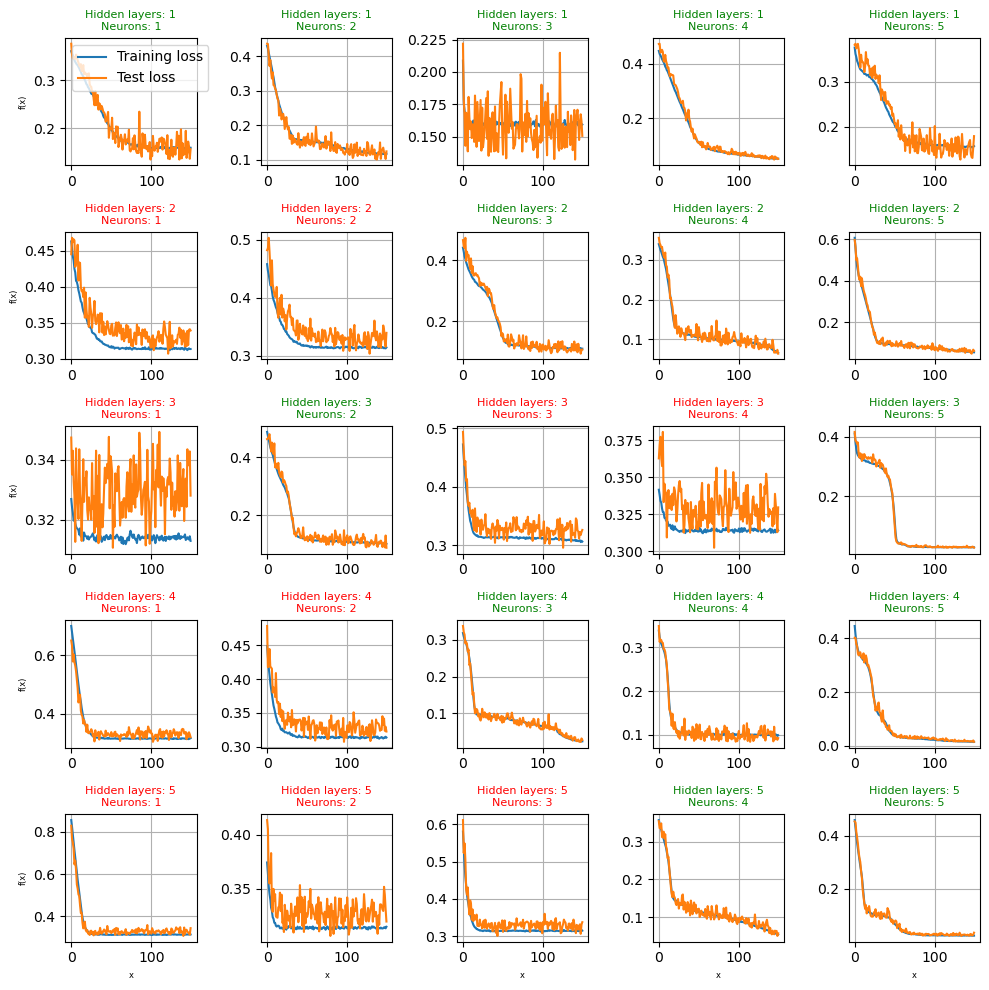

In [18]:
N_ROWS, N_COLS = len(num_hidden_layers_list), len(num_hidden_neurons_list)

fig, axs = plt.subplots(N_ROWS, N_COLS, figsize = (10,10))
for i in range(N_ROWS):
    for j in range(N_COLS):
        num_layers = num_hidden_layers_list[i]
        num_neurons = num_hidden_neurons_list[j]
        
        axs[i,j].plot(loss_dict[(num_layers,num_neurons)][0], label = "Training loss")
        axs[i,j].plot(loss_dict[(num_layers,num_neurons)][1], label = "Test loss")
        #axs[i,j].set_aspect(1.4)
        axs[i,j].grid()
        final_loss = loss_dict[(num_layers,num_neurons)][0][-1]
        if final_loss > 0.3:
            title_color = "red"
        else:
            title_color = "green"
        axs[i,j].set_title(f"Hidden layers: {num_layers}\nNeurons: {num_neurons}", 
                           color = title_color, fontsize = 8)

# Plot axis labels at the boundary plots
for i in range(N_COLS):
    axs[i,0].set_ylabel("f(x)", fontsize = 6)
for j in range(N_ROWS):
    axs[-1,j].set_xlabel("x", fontsize = 6)
    
axs[0,0].legend(fontsize = 10)
fig.tight_layout()

**Plot a pair of plots with reconstruction and loss function**

The code below allows to plot a selected pair of plots. The user can specify the number of hidden layers (`LAYERS`) and number of neurons in hidden layer (`NEURONS`) to use for the plot.

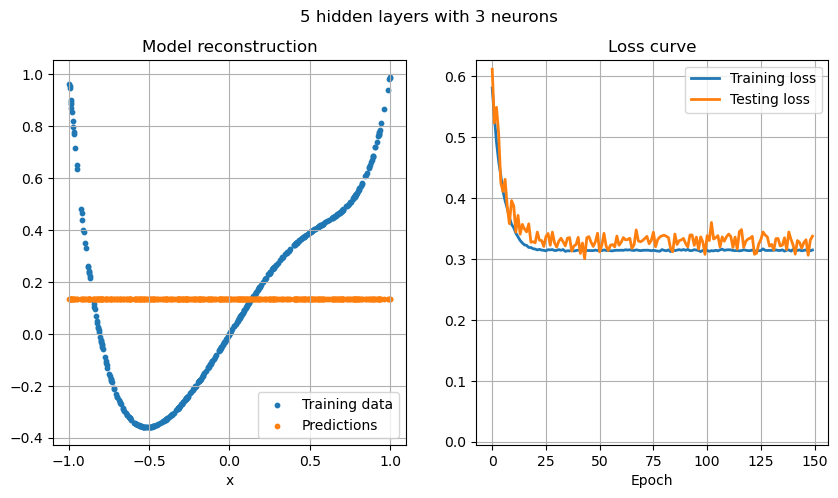

In [19]:
LAYERS, NEURONS = 5, 3

plt.subplots(nrows = 1, ncols =2, figsize = (10,5))
plt.suptitle(f"{LAYERS} hidden layers with {NEURONS} neurons")
# Plot the reconstruction
plt.subplot(1, 2, 1)
plt.scatter(X_test, y_test, s = 10, label = "Training data")
plt.scatter(X_test, reconstructions[(LAYERS,NEURONS)], s = 10, label = "Predictions")
plt.grid()
plt.xlabel("x")
plt.title("Model reconstruction")
plt.legend()
# Plot the loss
plt.subplot(1, 2, 2)
plt.plot(loss_dict[(LAYERS,NEURONS)][0], label = "Training loss", linewidth = 2)
plt.plot(loss_dict[(LAYERS,NEURONS)][1], label = "Testing loss", linewidth = 2)
plt.ylim(bottom = -0.005)
plt.grid()
plt.xlabel("Epoch")
plt.title("Loss curve")
plt.legend()

The plot above is an example of a failed training session, where the model did not learn anything. It is indicated by converging to a high loss

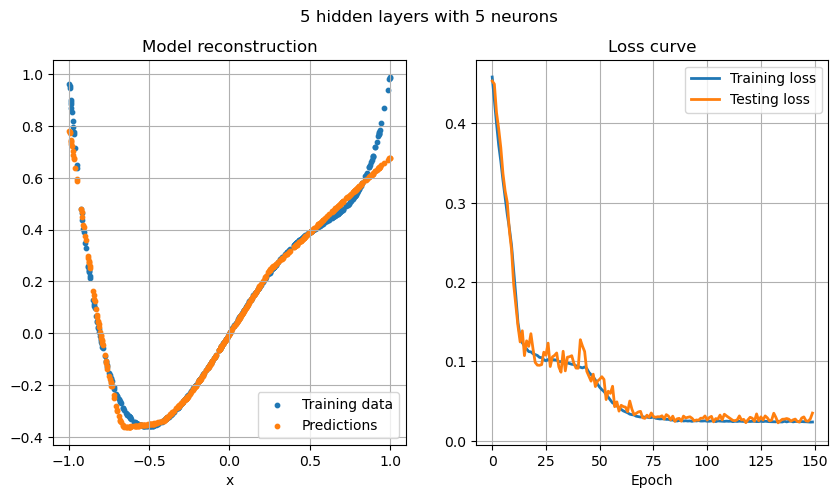

In [20]:
LAYERS, NEURONS = 5, 5

plt.subplots(nrows = 1, ncols =2, figsize = (10,5))
plt.suptitle(f"{LAYERS} hidden layers with {NEURONS} neurons")
# Plot the reconstruction
plt.subplot(1, 2, 1)
plt.scatter(X_test, y_test, s = 10, label = "Training data")
plt.scatter(X_test, reconstructions[(LAYERS,NEURONS)], s = 10, label = "Predictions")
plt.grid()
plt.xlabel("x")
plt.title("Model reconstruction")
plt.legend()
# Plot the loss
plt.subplot(1, 2, 2)
plt.plot(loss_dict[(LAYERS,NEURONS)][0], label = "Training loss", linewidth = 2)
plt.plot(loss_dict[(LAYERS,NEURONS)][1], label = "Testing loss", linewidth = 2)
plt.ylim(bottom = -0.005)
plt.grid()
plt.xlabel("Epoch")
plt.title("Loss curve")
plt.legend()

The plot above is an example of a healthy training session indicated by low final loss.